<a href="https://colab.research.google.com/github/Raspberry765/deep-metric-learning/blob/main/SubCenterArcFaceMNIST_LoF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.3/109.3 KB 1.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision

from pytorch_metric_learning import losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [ ]:
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) #MNISTのデータはグレースケールだから、channel数は1である
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch):
    model.train()
    loss_list = []
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        embeddings = model(data)
        loss = loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        loss_optimizer.step()
        if batch_idx % 100 == 0:
            print("Epoch {} Iteration {}: Loss = {}".format(epoch, batch_idx, loss))
            numpy_loss = loss.cpu().detach().numpy()
            loss_list.append(numpy_loss)
            #print(numpy_loss)            
    return loss_list


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, test_labels, train_embeddings, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))




## View some sample outliers

In [ ]:


img_mean, img_std = (0.1307,), (0.3081,) #MNISTの平均と標準偏差  https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457 


inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(img_mean, img_std)], std=[1 / s for s in img_std]
)


def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def imshow_many(dataset, outliers, n=32):
    imgs = [
        dataset[outliers[i]][0]
        for i in np.random.choice(
            len(outliers), size=min(n, len(outliers)), replace=False
        )
    ]
    imshow(torchvision.utils.make_grid(imgs))

In [ ]:
device = torch.device("cuda")


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(img_mean, img_std)]
) #MNISTの平均と標準偏差を画像に対して前処理を行うためのパラメーター

batch_size = 64

dataset1 = datasets.MNIST(".", train=True, download=True, transform=transform) #トランスフォームを適用して、ダウンロード
dataset2 = datasets.MNIST(".", train=False, transform=transform) #トランスフォームを適用して、ダウンロード
train_loader = torch.utils.data.DataLoader(
    dataset1, batch_size=batch_size, shuffle=True
)


test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size) #batch sizeは2**n deep learning C2 w2 optimization algorithms

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)#defalut lr=0.01
num_epochs = 2


### pytorch-metric-learning stuff ###
loss_func = losses.SubCenterArcFaceLoss(num_classes=10, embedding_size=128).to(device)
loss_optimizer = torch.optim.Adam(loss_func.parameters(), lr=1e-4)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###

## Train the model

In [ ]:
sum_loss_list = []
for epoch in range(1, num_epochs + 1):
    loss_list = train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch)
    print(loss_list)
    sum_loss_list.extend(loss_list)
    test(dataset1, dataset2, model, accuracy_calculator)
print(sum_loss_list)

Epoch 1 Iteration 0: Loss = 37.535011291503906
Epoch 1 Iteration 100: Loss = 6.5896196365356445
Epoch 1 Iteration 200: Loss = 4.102725982666016
Epoch 1 Iteration 300: Loss = 3.025817394256592
Epoch 1 Iteration 400: Loss = 2.171595811843872
Epoch 1 Iteration 500: Loss = 2.6152045726776123
Epoch 1 Iteration 600: Loss = 2.505932092666626
Epoch 1 Iteration 700: Loss = 3.6543660163879395
Epoch 1 Iteration 800: Loss = 2.130096673965454
Epoch 1 Iteration 900: Loss = 3.0290427207946777
[array(37.53501, dtype=float32), array(6.5896196, dtype=float32), array(4.102726, dtype=float32), array(3.0258174, dtype=float32), array(2.1715958, dtype=float32), array(2.6152046, dtype=float32), array(2.505932, dtype=float32), array(3.654366, dtype=float32), array(2.1300967, dtype=float32), array(3.0290427, dtype=float32)]


100%|██████████| 313/313 [00:02<00:00, 121.64it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9858
Epoch 2 Iteration 0: Loss = 0.6620765328407288
Epoch 2 Iteration 100: Loss = 1.7081005573272705
Epoch 2 Iteration 200: Loss = 0.8925427198410034
Epoch 2 Iteration 300: Loss = 1.2147045135498047
Epoch 2 Iteration 400: Loss = 1.6539250612258911
Epoch 2 Iteration 500: Loss = 2.817596673965454
Epoch 2 Iteration 600: Loss = 1.9930663108825684
Epoch 2 Iteration 700: Loss = 4.679912567138672
Epoch 2 Iteration 800: Loss = 1.2931218147277832
Epoch 2 Iteration 900: Loss = 0.19532203674316406
[array(0.66207653, dtype=float32), array(1.7081006, dtype=float32), array(0.8925427, dtype=float32), array(1.2147045, dtype=float32), array(1.6539251, dtype=float32), array(2.8175967, dtype=float32), array(1.9930663, dtype=float32), array(4.6799126, dtype=float32), array(1.2931218, dtype=float32), array(0.19532204, dtype=float32)]


100%|██████████| 313/313 [00:02<00:00, 118.72it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9870000000000001
[array(37.53501, dtype=float32), array(6.5896196, dtype=float32), array(4.102726, dtype=float32), array(3.0258174, dtype=float32), array(2.1715958, dtype=float32), array(2.6152046, dtype=float32), array(2.505932, dtype=float32), array(3.654366, dtype=float32), array(2.1300967, dtype=float32), array(3.0290427, dtype=float32), array(0.66207653, dtype=float32), array(1.7081006, dtype=float32), array(0.8925427, dtype=float32), array(1.2147045, dtype=float32), array(1.6539251, dtype=float32), array(2.8175967, dtype=float32), array(1.9930663, dtype=float32), array(4.6799126, dtype=float32), array(1.2931218, dtype=float32), array(0.19532204, dtype=float32)]


20


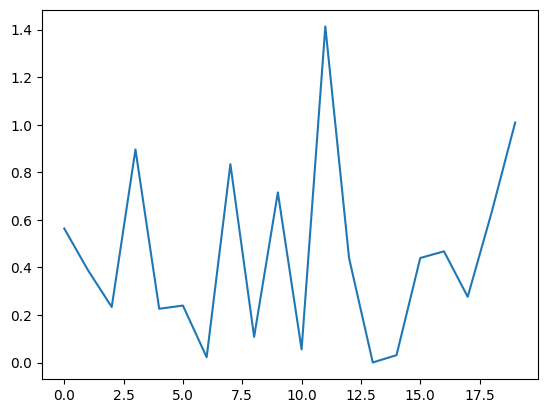

In [ ]:
#print(type(loss_list[0]))
print(len(sum_loss_list))
x = np.arange(len(sum_loss_list)) #-5から5まで0.1区切りで配列を作る
y = sum_loss_list #配列xの値に関してそれぞれsin(x)を求めてy軸の配列を生成

plt.plot(x,y) # この場合のplot関数の第一引数xは、x軸に対応し、第二引数のyがy軸にあたります。
plt.show()

# modelを保存

In [ ]:
torch.save(model, 'model_dml.pth')

#modelデータのロードをする
# trainデータを埋め込みする



In [ ]:
load_model = torch.load('model_dml.pth')
train_embeddings, train_labels = get_all_embeddings(dataset1, load_model)

100%|██████████| 1875/1875 [00:16<00:00, 111.99it/s]


## Get outliers(MNISTの文字データのtrainデータを異常検知している)

There are 164 outliers


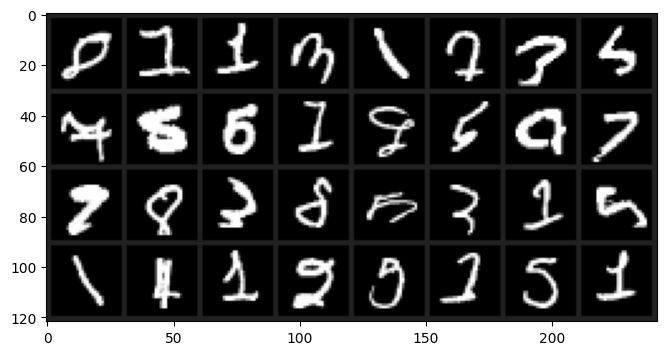

In [ ]:
outliers, _ = loss_func.get_outliers(train_embeddings, train_labels.squeeze(1)) #train modelを異常検知している #lr=0.01 outlier=98
print(f"There are {len(outliers)} outliers")
imshow_many(dataset1, outliers)

In [ ]:
# let's see what outliers are.
# these are the samples that >threshold degrees aways from their dominant centers


# testデータを埋め込みする

In [ ]:
test_embeddings, test_labels = get_all_embeddings(dataset2, model)

100%|██████████| 313/313 [00:02<00:00, 116.46it/s]


## Get outliers(MNISTの文字データのtestデータを異常検知している)

There are 11 outliers(MNIST 10000 test items)


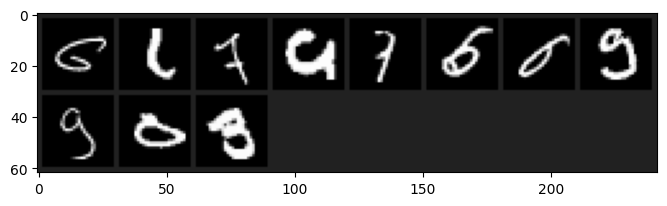

In [ ]:
outliers, _ = loss_func.get_outliers(test_embeddings, test_labels.squeeze(1)) #train modelを異常検知している #lr=0.01 outlier=98
print(f"There are {len(outliers)} outliers(MNIST 10000 test items)")
# let's see what outliers are.
# these are the samples that >threshold degrees aways from their dominant centers
imshow_many(dataset2, outliers)

In [ ]:
# transform to normalize the data
fashion_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
fashion_trainset = datasets.FashionMNIST('.', download=True, train=True, transform=fashion_transform )
fashion_testset = datasets.FashionMNIST('.', download=True, train=False, transform=fashion_transform )

# train fashionデータとtest fashionデータを埋め込みする

In [ ]:
train_fashion_embeddings, train_fashion_labels = get_all_embeddings(fashion_trainset, model)
test_fashion_embeddings, test_fashion_labels = get_all_embeddings(fashion_testset, model)

100%|██████████| 313/313 [00:03<00:00, 102.46it/s]


In [ ]:
outliers, _ = loss_func.get_outliers(train_fashion_embeddings, train_fashion_labels.squeeze(1)) #train modelを異常検知している #lr=0.01 outlier=98
print(f"There are {len(outliers)} outliers(train_fashion 60000 items)")
outliers, _ = loss_func.get_outliers(test_fashion_embeddings, test_fashion_labels.squeeze(1)) #train modelを異常検知している #lr=0.01 outlier=98
print(f"There are {len(outliers)} outliers(train_fashion 10000 items)")

There are 43690 outliers(train_fashion 60000 items)
There are 7319 outliers(train_fashion 10000 items)
